# What fields in taxdata are collinear?

Apparently:
* `e00650` and `e00600`
* `e19800` and `e20100`

## Setup

In [1]:
import taxcalc as tc
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(os.path.join(tc.Records.CUR_PATH, 'cps.csv.gz'))

## Check `e00650` and `e00600`

As was hypothesized.

In [3]:
np.corrcoef(df.e00650, df.e00600)[0][1]

0.99956451611861186

In [4]:
df.shape[0]

456465

In [5]:
df_e00650_e00600 = df[(df.e00650 + df.e00600) > 0.]

In [6]:
df_e00650_e00600.shape[0]

126505

In [7]:
np.corrcoef(df_e00650_e00600.e00650, df_e00650_e00600.e00600)[0][1]

0.99956582657494664

## Is `e01100` collinear with others?

In [8]:
predictors = [
    'DSI', 'EIC', 'MARS', 'XTOT', 'e00200', 'e00300', 'e00400','e00600',
    'e00800', 'e00900', 'e01400', 'e01500', 'e01700','e02100', 'e02300', 
    'e02400', 'e03150', 'e03210', 'e03240', 'e03270','e03300', 'e17500', 
    'e18400', 'e18500', 'e19200', 'e19800', 'e20100','e20400', 'e32800', 
    'f2441', 'n24']
predictors_plus_e01100 = predictors + ['e01100']

In [9]:
for i in predictors:
    corr = np.corrcoef(df.e01100, df[i])[0][1]
    print(i + ': ' + corr.astype(str))

DSI: -0.00943423201959
EIC: 7.48279041637e-06
MARS: 0.0165217293794
XTOT: 0.0179244964297
e00200: 0.0242090747824
e00300: 0.0413804917623
e00400: 0.104999056777
e00600: 0.00178937850128
e00800: -0.000352717761821
e00900: 0.0131502490407
e01400: 0.00621748268821
e01500: 0.00963262791038
e01700: 0.00867674069107
e02100: -0.00127081388506
e02300: -0.0025545334211
e02400: 0.013436096883
e03150: 0.00923146953027
e03210: 0.00516462671525
e03240: 0.0184532039415
e03270: 0.00469268161616
e03300: 0.0061969642544
e17500: 0.00784004498532
e18400: 0.0976477093074
e18500: 0.118052544972
e19200: 0.100916850333
e19800: 0.0234195161821
e20100: 0.0234226362954
e20400: 0.0026808891064
e32800: 0.0054747590789
f2441: 0.000487883822811
n24: 0.000929575348699


No not really.

## Check general collinearity

Check collinearity per https://stackoverflow.com/a/25833792/1840471. Any value close to 0 in the eigenvector points to collinearity.

In [10]:
def min_eig(df):
    corr = np.corrcoef(df, rowvar=0)
    w, v = np.linalg.eig(corr) 
    return w.min()

In [11]:
min_eig(df[predictors_plus_e01100])

5.0075676315020712e-08

Now after removing `e001100`.

In [12]:
min_eig(df[predictors])

5.0076222077280099e-08

Remove each feature from `predictors` to see what's causing the low value.

In [13]:
for i in predictors_plus_e01100:
    print(i + ': ' + 
          min_eig(df[predictors_plus_e01100].drop(i, axis=1)).astype(str))

DSI: 5.00762231406e-08
EIC: 5.00757408019e-08
MARS: 5.0076197714e-08
XTOT: 5.00756776324e-08
e00200: 5.01643203711e-08
e00300: 5.00777282012e-08
e00400: 5.00766030174e-08
e00600: 5.00756784009e-08
e00800: 5.00758275672e-08
e00900: 5.00787845089e-08
e01400: 5.00758299244e-08
e01500: 5.00763329675e-08
e01700: 5.00757520751e-08
e02100: 5.01060467431e-08
e02300: 5.00769688113e-08
e02400: 5.00789293443e-08
e03150: 5.00756870268e-08
e03210: 5.00761758863e-08
e03240: 5.00849786381e-08
e03270: 5.00769045568e-08
e03300: 5.00784438891e-08
e17500: 5.00758724896e-08
e18400: 5.01323240733e-08
e18500: 5.00806773239e-08
e19200: 5.00918667783e-08
e19800: 0.0290156273866
e20100: 0.0290156273282
e20400: 5.00773499209e-08
e32800: 5.00756766236e-08
f2441: 5.00772370311e-08
n24: 5.00757110602e-08
e01100: 5.00762220773e-08


## `e19800` vs `e20100`

Looks like `e19800` and `e20100`, defined respectively as "Itemizable charitable giving: cash/check contributions. WARNING: this variable is already capped in PUF data." and "Itemizable charitable giving: other than cash/check contributions. WARNING: this variable is already capped in PUF data."

In [14]:
np.corrcoef(df.e19800, df.e20100)[0][1]

0.99999994878238485

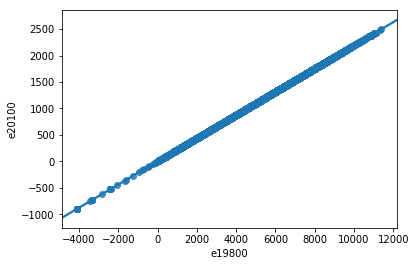

In [15]:
sns.regplot(df.e19800, df.e20100)
plt.show()

## Re-run collinearity with `e19800` and `e20100` merged

These should be added into a single feature, since the CPS data [splits them based on a constant proportion]( https://github.com/open-source-economics/taxdata/blob/4f86528bc264f11fe70583cbf35a2a4a5b8b7983/cps_data/finalprep.py#L149).

In [16]:
df['e19800_e20100'] = df.e19800 + df.e20100

In [17]:
predictors = [
    'DSI', 'EIC', 'MARS', 'XTOT', 'e00200', 'e00300', 'e00400','e00600',
    'e00800', 'e00900', 'e01400', 'e01500', 'e01700','e02100', 'e02300', 
    'e02400', 'e03150', 'e03210', 'e03240', 'e03270','e03300', 'e17500', 
    'e18400', 'e18500', 'e19200', 'e19800_e20100','e20400', 'e32800', 
    'f2441', 'n24', 'e01100']

In [18]:
for i in predictors:
    print(i + ': ' + 
          min_eig(df[predictors].drop(i, axis=1)).astype(str))

DSI: 0.0290986734
EIC: 0.0673337757569
MARS: 0.029199622059
XTOT: 0.0291234066378
e00200: 0.0290196614152
e00300: 0.029015725856
e00400: 0.0290167782683
e00600: 0.0290156292321
e00800: 0.0290162850995
e00900: 0.0290157083031
e01400: 0.0290157226414
e01500: 0.0290162450703
e01700: 0.0290157308543
e02100: 0.0290247565738
e02300: 0.0290161356589
e02400: 0.0290239357172
e03150: 0.0290156892396
e03210: 0.0290157522712
e03240: 0.0290161595361
e03270: 0.029015776976
e03300: 0.0290156322524
e17500: 0.0290156301711
e18400: 0.0290187225997
e18500: 0.0290508368223
e19200: 0.0291020217076
e19800_e20100: 0.0290157740373
e20400: 0.0290156943474
e32800: 0.0290713911359
f2441: 0.0301672283313
n24: 0.0673339942005
e01100: 0.0290168595775


In [19]:
np.corrcoef(df.EIC, df.n24)[0][1]

0.96909184099968071